In [1]:
import numpy as np
import pandas as pd
from utils import read_q_mat, read_a_mat
import scipy.io
import keras
from sim import model_setup, sim_hb, std_operating_policy, max_release, min_release, level_to_storage
import matplotlib.pyplot as plt
import seaborn as sns



In [2]:
start_date = '1996-01-01'
end_date = '2005-01-01'
q_vu = '/Users/cooper/Desktop/optimal-wat-allocation/Script/MAT_data/q_vuquang.mat'
q_ye = '/Users/cooper/Desktop/optimal-wat-allocation/Script/MAT_data/q_yenbai.mat'
a = '/Users/cooper/Desktop/optimal-wat-allocation/Script/MAT_data/a_hoabinh_K.mat'

qq, sys_params = model_setup(
    ini_date=start_date,
    fin_date=end_date,
    path_a_hoabinh_K=a,
    path_q_vuquang=q_vu,
    path_q_yenbai=q_ye,
)

In [3]:
policy = (89, 107, 1.57, 1.5704, 5000)

h, u, r, ht_HN = sim_hb(
    qq=qq,
    h_in=104,
    policy=policy,
    sys_param=sys_params
)

103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 357us/step


/opt/anaconda3/envs/remSensEnv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


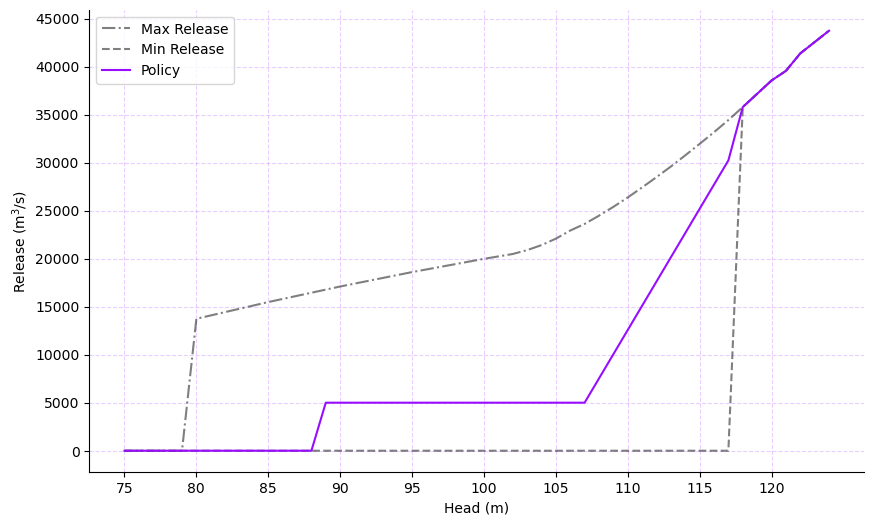

In [24]:
h_levels = [i for i in range(75, 125, 1)]
s_levels = [level_to_storage(h, sys_params) for h in h_levels]
std_releases = [std_operating_policy(h, policy, debug=False) for h in h_levels]
max_releases = [max_release(s, sys_params) for s in s_levels]
min_releases = [min_release(s, sys_params) for s in s_levels]

df = pd.DataFrame({
    'h': h_levels,
    's': s_levels,
    'std_release': std_releases,
    'max_release': max_releases,
    'min_release': min_releases
})

df['actual_release'] = np.where(((df['std_release'] < df['max_release']) & (df['std_release'] >= df['min_release'])), df['std_release'], df['max_release'])


fig = plt.figure(figsize=(10, 6))


plt.plot(df['h'], df['max_release'], label='Max Release', linestyle='-.', alpha=0.5, color='black')
plt.plot(df['h'], df['min_release'], label='Min Release', linestyle='--', alpha=0.5, color='black')
plt.plot(df['h'], df['actual_release'], label='Policy', color='#980DFF')
plt.xlabel('Head (m)')
plt.ylabel('Release (m$^3$/s)')
sns.despine()
plt.grid(alpha=0.2, linestyle='--', color='#980DFF')
plt.xticks(np.arange(75, 125, 5))
plt.yticks(np.arange(0, 50000, 5000))
plt.legend()
plt.show()



